In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#데이터 증강
## 기존의 데이터를 변형해서 데이터의 양을 늘리는 것을 데이터 증강
- Keras의 ImageDataGenerator를 사용해서 데이터 증강을 확인

In [2]:
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/PetImages.zip" -d "/content/drive/MyDrive/Colab Notebooks/datasets"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/7272.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/__MACOSX/PetImages/Dog/._7272.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/8141.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/__MACOSX/PetImages/Dog/._8141.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/1603.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/__MACOSX/PetImages/Dog/._1603.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/397.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/__MACOSX/PetImages/Dog/._397.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/5465.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks/datasets/__MACOSX/PetImages/Dog/._5465.jpg  
  inflating: /content/drive/MyDrive/Colab Notebooks

In [3]:
!rm -rf "/content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Cat/666.jpg"
!rm -rf "/content/drive/MyDrive/Colab Notebooks/datasets/PetImages/Dog/11702.jpg"

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 데이터 생성기 설정
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# 훈련 데이터셋 생성
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/datasets/PetImages',
    target_size=(224, 224),  # 이미지 크기 조절
    batch_size=32,
    class_mode='binary',  # 이진 분류인 경우 'binary'
    subset='training'  # 훈련 데이터 설정
)

# 테스트 데이터셋 생성
test_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/datasets/PetImages',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # 검증 데이터 설정
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [5]:
import tensorflow as tf

devices = tf.config.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## VGG

In [9]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 가져오기 (include_top=False로 설정하여 fully connected layers를 포함하지 않도록 설정)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential()

model.add(base_model)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # 2 클래스(고양이, 개) 이진 분류의 경우

# 기존 모델의 가중치를 동결하여 훈련하지 않도록 설정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(patience=3)  # 성능 개선이 없는 경우 3번의 에포크 동안 훈련을 조기 종료

with tf.device('/GPU:0'):
    # 모델 훈련
    hist_vgg = model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/20
503/625 [=======================>......] - ETA: 16s - loss: 0.2885 - accuracy: 0.8923

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 110s 174ms/step - loss: 0.2686 - accuracy: 0.8988 - val_loss: 0.1702 - val_accuracy: 0.9330
Epoch 2/20
625/625 [==============================] - 107s 172ms/step - loss: 0.1382 - accuracy: 0.9433 - val_loss: 0.1697 - val_accuracy: 0.9302
Epoch 3/20
625/625 [==============================] - 107s 171ms/step - loss: 0.1058 - accuracy: 0.9574 - val_loss: 0.1774 - val_accuracy: 0.9354
Epoch 4/20
625/625 [==============================] - 107s 171ms/step - loss: 0.0809 - accuracy: 0.9672 - val_loss: 0.1935 - val_accuracy: 0.9320
Epoch 5/20
625/625 [==============================] - 108s 172ms/step - loss: 0.0707 - accuracy: 0.9722 - val_loss: 0.2022 - val_accuracy: 0.9286


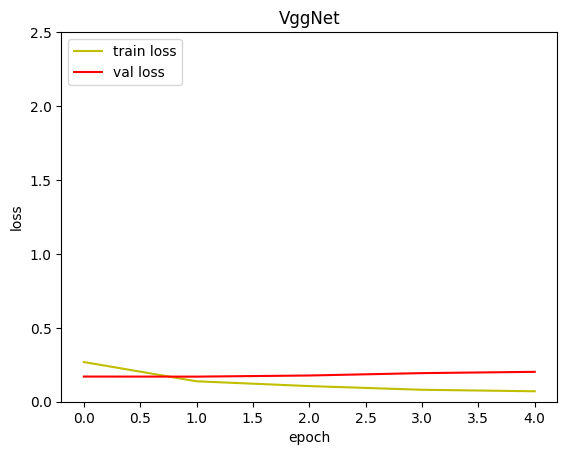

In [10]:
import matplotlib.pyplot as plt

plt.plot(hist_vgg.history['loss'], 'y', label='train loss')
plt.plot(hist_vgg.history['val_loss'], 'r', label='val loss')

plt.ylim([0.0, 2.5])

plt.title("VggNet")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')
plt.show()

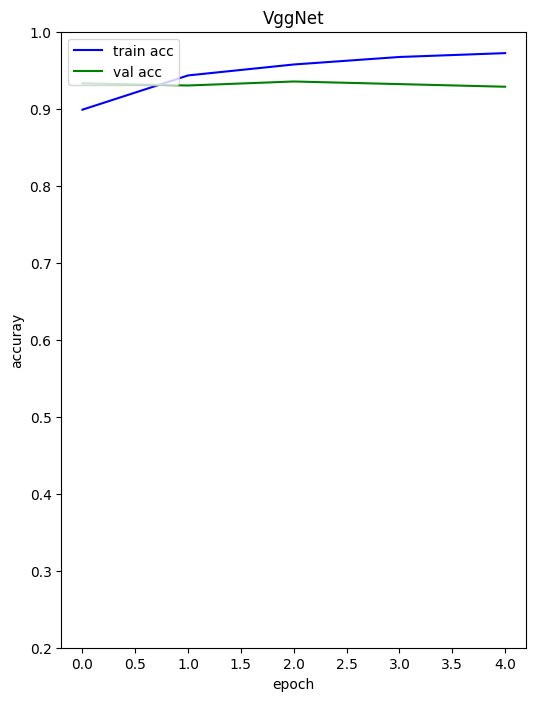

In [11]:
plt.figure(figsize=(6,8))
plt.plot(hist_vgg.history['accuracy'], 'b', label='train acc')
plt.plot(hist_vgg.history['val_accuracy'], 'g', label='val acc')

plt.ylim([0.2, 1.0])

plt.title("VggNet")
plt.xlabel('epoch')
plt.ylabel('accuray')

plt.legend(loc='upper left')

plt.show()

## Efficient

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

base_model = EfficientNetB0(weights=None, include_top=True, classes=1, classifier_activation='sigmoid', input_shape=(224, 224, 3))

# 모델 컴파일
base_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(patience=3)  # 성능 개선이 없는 경우 3번의 에포크 동안 훈련을 조기 종료

with tf.device('/GPU:0'):
  # 모델 훈련
  hist_efficient = base_model.fit(train_generator, epochs=20, validation_data=test_generator, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 229s 304ms/step - loss: 1.1552 - accuracy: 0.5483 - val_loss: 0.8023 - val_accuracy: 0.5002
Epoch 2/20
625/625 [==============================] - 187s 299ms/step - loss: 0.7257 - accuracy: 0.6205 - val_loss: 0.6430 - val_accuracy: 0.6427
Epoch 3/20
625/625 [==============================] - 187s 300ms/step - loss: 0.6607 - accuracy: 0.6703 - val_loss: 0.5701 - val_accuracy: 0.7015
Epoch 4/20
625/625 [==============================] - 190s 303ms/step - loss: 0.5742 - accuracy: 0.7191 - val_loss: 0.5038 - val_accuracy: 0.7671
Epoch 5/20
625/625 [==============================] - 190s 303ms/step - loss: 0.5178 - accuracy: 0.7628 - val_loss: 0.8532 - val_accuracy: 0.7023
Epoch 6/20
625/625 [==============================] - 189s 302ms/step - loss: 0.5069 - accuracy: 0.7792 - val_loss: 1.0276 - val_accuracy: 0.7341
Epoch 7/20
625/625 [==============================] - 189s 302ms/step - loss: 0.4061 - accuracy: 0.8177 - val_loss: 0.3980 -

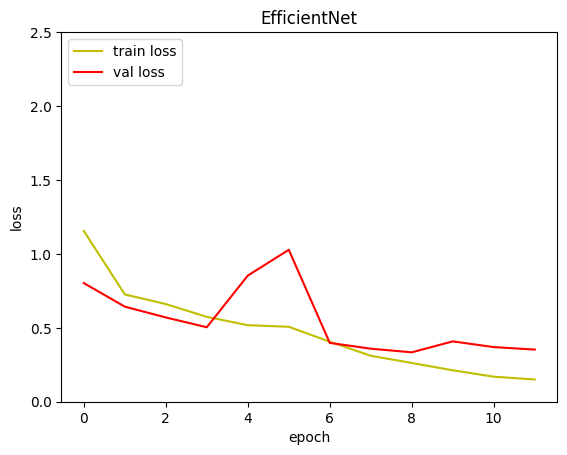

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist_efficient.history['loss'], 'y', label='train loss')
plt.plot(hist_efficient.history['val_loss'], 'r', label='val loss')

plt.ylim([0.0, 2.5])

plt.title("EfficientNet")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend(loc='upper left')
plt.show()

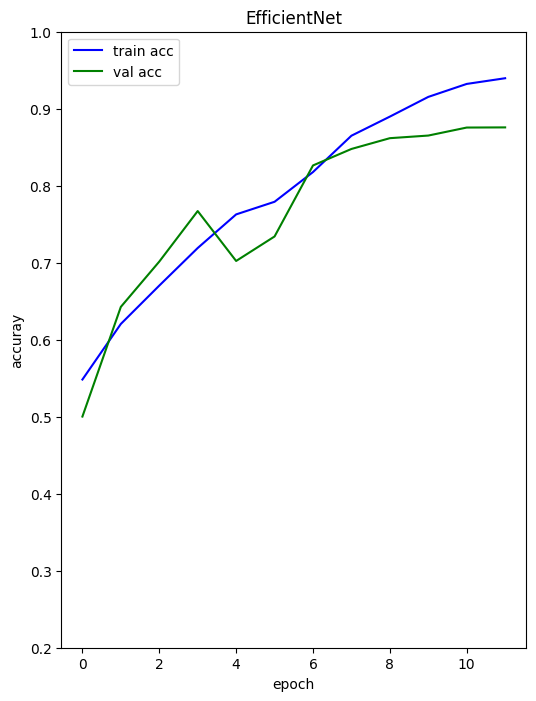

In [15]:
plt.figure(figsize=(6,8))
plt.plot(hist_efficient.history['accuracy'], 'b', label='train acc')
plt.plot(hist_efficient.history['val_accuracy'], 'g', label='val acc')

plt.ylim([0.2, 1.0])

plt.title("EfficientNet")
plt.xlabel('epoch')
plt.ylabel('accuray')

plt.legend(loc='upper left')

plt.show()